# Testbed for TF2 Optimizers

Inspired by machinelearningmastery.com [blog posting](https://machinelearningmastery.com/gradient-descent-optimization-with-nadam-from-scratch/)

Requires TF 2.x

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf

## Setup

In [241]:
def loss_function0(x):
    return tf.reduce_sum((x * LOSS_FUNCTION_DIMENSION_SCALING)**2, axis=-1)

def loss_function1(x):
    return tf.reduce_sum(tf.math.cos(x * LOSS_FUNCTION_DIMENSION_SCALING)**2, axis=-1)

# select loss function to use
loss_function = loss_function0

In [242]:
IMAGE_DIR = None #'./images/large-lr'
AXIS_LIMIT = 3
MAX_ITERATIONS = 1000
LEARNING_RATE = 0.01
INITIAL_POINT = [1.7, -1.5] #[0.001, 0.001] #[1.5, 0.01] #[1.7, -1.5]
LOSS_FUNCTION_DIMENSION_SCALING = [1, 1]
OPTIMIZERS = [
    tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE),
    tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    tf.keras.optimizers.Nadam(learning_rate=LEARNING_RATE),    
    tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),
    tf.keras.optimizers.Adagrad(learning_rate=LEARNING_RATE),
    tf.keras.optimizers.Adadelta(learning_rate=LEARNING_RATE),
]

## Display Loss Surface For Reference

In [243]:
if IMAGE_DIR is not None:
    # setup directory for image save
    os.makedirs(IMAGE_DIR, exist_ok=True)

In [244]:
# generate plot points
x = tf.range(-AXIS_LIMIT, AXIS_LIMIT, 0.1, dtype=tf.float32)
y = tf.range(-AXIS_LIMIT, AXIS_LIMIT, 0.1, dtype=tf.float32)

t_list = tf.meshgrid(x, y, indexing='ij')
t = tf.stack(t_list, axis=-1)

# generate loss surface
loss_surface = loss_function(t)

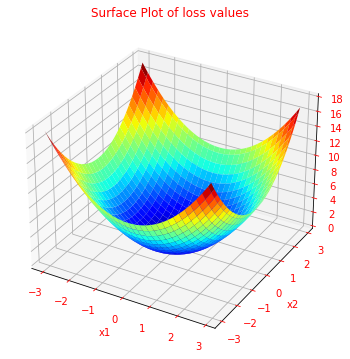

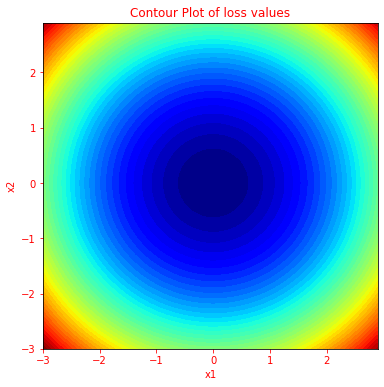

In [245]:

# display surface plot for loss_surface
figure = plt.figure(figsize=(6,6))
axis = figure.gca(projection='3d')
axis.plot_surface(t_list[0], t_list[1], 
                  loss_surface.numpy(), cmap='jet')

axis.tick_params(axis='both', colors='r')
axis.set_xlabel('x1', color='r')
axis.set_ylabel('x2', color='r')
# show the plot
plt.title('Surface Plot of loss values', color='r')
if IMAGE_DIR is not None:
    plt.savefig(os.path.join(IMAGE_DIR, 'surface_plot.png'))
plt.show()

# display contour plot version
figure = plt.figure(figsize=(6,6))
axis = figure.gca()
plt.contourf(t_list[0], t_list[1], loss_surface, levels=50, cmap='jet')
axis.tick_params(axis='both', colors='r')
axis.set_xlabel('x1', color='r')
axis.set_ylabel('x2', color='r')
# show the plot
plt.title('Contour Plot of loss values', color='r')
if IMAGE_DIR is not None:
    plt.savefig(os.path.join(IMAGE_DIR, 'contour_plot.png'))
plt.show()

## Test out different optimizers on the loss surface

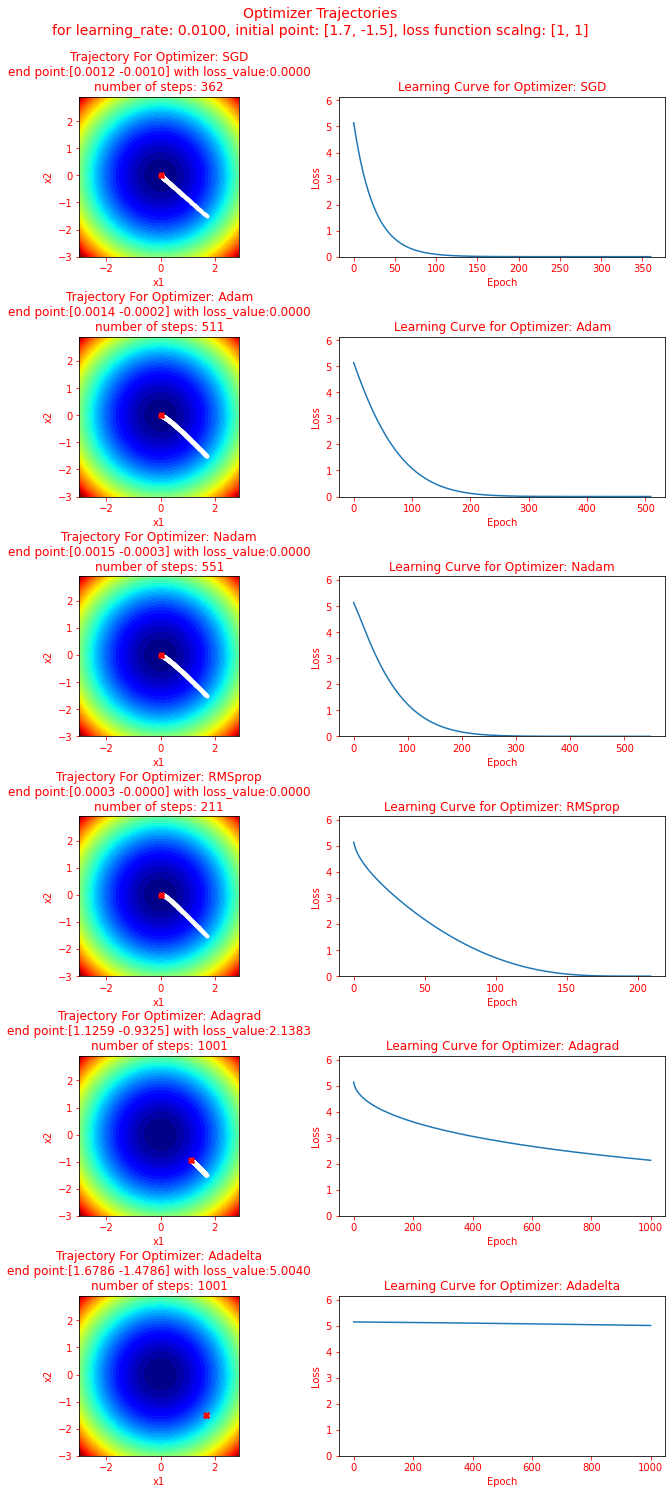

In [246]:
fig, ax = plt.subplots(6, 2, figsize=(12, 25))
#fig2, ax2 = plt.subplots(3, 2, sharey='row', figsize=(12, 20))
for idx, optimizer in enumerate(OPTIMIZERS):
    row = idx 
    ax[row, 0].set_aspect(1)
    plt_ax = ax[row, 0]
    plt_ax2 = ax[row, 1]

    # setup for looping through optimizers
    x = tf.Variable(INITIAL_POINT, dtype=tf.float32)  # set initial point
    trajectory_points = [[x.numpy(), np.nan]]   # record initial starting point
    for _ in range(MAX_ITERATIONS):

        #calculate loss function 
        with tf.GradientTape() as tape:
            loss = loss_function(x)

        # calculate gradient
        var_list = [x]
        grad = tape.gradient(loss, var_list)

        # update solution using the calculated gradient
        optimizer.apply_gradients(zip(grad, var_list))
        trajectory_points.append([x.numpy(), loss.numpy()])
        
        # test if we are approaching a limit point, early stopping
        if len(trajectory_points) > 3:
            if np.abs(loss_function(trajectory_points[-1][0]) 
                      - loss_function(trajectory_points[-2][0])) < 1e-7:
                break

    
    # consolidate the trajectory the optimizer
    trajectory = np.stack(
        # [x1_loc, x2_loc, loss_value]
        [ [x[0][0], x[0][1], x[1]] for x in trajectory_points]
    )
    
    
    # generate subplot for this optimizer
    # add contour plot
    plt_ax.contourf(t_list[0], t_list[1], loss_surface, levels=50, cmap='jet')
    
    # overlay optimizer trajectory path
    plt_ax.plot(trajectory[:,0], trajectory[:,1], '.-', color='w')
    
    # plot final point
    plt_ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'X', color='r')

    # add title for subplot
    plot_title = 'Trajectory For Optimizer: ' + optimizer._name 
    plot_title += '\nend point:' + np.array2string(trajectory[-1][:2], 
                                           formatter={'float': lambda x: "%.4f" % x})
    plot_title += ' with loss_value:' + np.array2string(trajectory[-1][2],
                                                   formatter={'float': lambda x: "%.4f" % x})
    plot_title += '\nnumber of steps: ' + '%d' % len(trajectory)
    plt_ax.tick_params(axis='both', colors='red')
    plt_ax.set_xlabel('x1', color='r')
    plt_ax.set_ylabel('x2', color='r')
    plt_ax.set_title(plot_title, color='r')
    
    plt_ax2.plot(range(trajectory.shape[0]-1), trajectory[1:, 2])
    y_max = np.nanmax(trajectory[:,2]) + 1
    plt_ax2.set(ylim=(0, y_max))
    plt_ax2.tick_params(axis='both', colors='red')
    plt_ax2.set_xlabel('Epoch', color='r')
    plt_ax2.set_ylabel('Loss', color='r')
    plt_ax2.set_title('Learning Curve for Optimizer: ' + optimizer._name, color='r')
    
    

# display all the subplots
sup_title = 'Optimizer Trajectories'
sup_title += '\nfor learning_rate: %.4f' % LEARNING_RATE
sup_title += ', initial point: ' + str(INITIAL_POINT)
sup_title += ', loss function scalng: ' + str(LOSS_FUNCTION_DIMENSION_SCALING)
fig.subplots_adjust(hspace=0.5, wspace=0.05)
fig.suptitle(sup_title, fontsize=14, color='r', y=0.93)

if IMAGE_DIR is not None:
    plt.savefig(os.path.join(IMAGE_DIR, 'optimizer_plots.png'))
plt.show()